In [22]:
import numpy as np
import sklearn as sk
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.decomposition import PCA
from sklearn import linear_model

import warnings
warnings.filterwarnings('ignore')

# Functions

In [23]:
def find_correlation(data, threshold=0.9):
    corr_mat = data.corr()
    corr_mat.loc[:, :] = np.tril(corr_mat, k=-1)
    already_in = set()
    result = []
    for col in corr_mat:
        perfect_corr = corr_mat[col][abs(corr_mat[col])> threshold].index.tolist()
        if perfect_corr and col not in already_in:
            already_in.update(set(perfect_corr))
            perfect_corr.append(col)
            result.append(perfect_corr)
    select_nested = [f[1:] for f in result]
    select_flat = [i for j in select_nested for i in j]
    return select_flat

In [24]:
def generate_stat(X_stat):
    for names in X_stat.drop(columns=['city','year','weekofyear','week_start_date']):
        X_stat['month_avg_'+names] = X_stat[names].rolling(3 ,min_periods=1).mean()
        X_stat['month_min_'+names] = X_stat[names].rolling(3 ,min_periods=1).min()
        X_stat['month_max_'+names] = X_stat[names].rolling(3 ,min_periods=1).max()
        X_stat['lag_3_'+names] = X_stat[names].shift(2)
    return X_stat

In [25]:
def PP_X(X1):
    X1 = X1[(X1['city']=='sj')]
    le = preprocessing.LabelEncoder()
    X1['city'] = le.fit_transform(X1['city'])
    X1['week_start_date'] = pd.to_datetime(X1['week_start_date'])
    X1['ndvi_s'] = X1['ndvi_se'] + X1['ndvi_sw']
    X1['ndvi_n'] = X1["ndvi_ne"] + X1['ndvi_nw']
    X1 = generate_stat(X1)
#     X1['month'] = pd.DatetimeIndex(X1['week_start_date']).month
    X1 = X1.fillna(method = 'bfill')

    X1 = X1.drop(
        columns=[
            'weekofyear', 
            'week_start_date',
            'city',
            'year'
        ]
    )
    
    return X1

In [6]:
def PP_Y(Y1):
    Y1 = Y1[(Y1['city']=='sj')]
    return Y1

## Read and clean data

In [26]:
X = pd.read_csv("dengue_features_train.csv")
Y = pd.read_csv("dengue_labels_train.csv")
X_New = pd.read_csv("dengue_features_test.csv")
Y_New = pd.read_csv('submission_format.csv')
X , X_New = PP_X(X) , PP_X(X_New)
Y , Y_New = PP_Y(Y) , PP_Y(Y_New)

## Principal Componant Analysis

In [7]:
pca = PCA(n_components=10)
X2 = pd.DataFrame(pca.fit_transform(X))
X = pd.concat([X,X2],axis=1)
X_New2 = pd.DataFrame(pca.transform(X_New))
X_New = pd.concat([X_New,X_New2],axis=1)

## Drop Highly Correlated Data

In [13]:
columns_to_drop = find_correlation(X_New , 0.9)
X = X.drop(columns=columns_to_drop)
X_New = X_New.drop(columns=columns_to_drop)

## Rmove Outliers

In [14]:
X , Y = X.loc[Y['total_cases'] <150] , Y.loc[Y['total_cases'] <150]
Xrf = X
Yrf = Y['total_cases'].values.ravel()
X_testrf = X_New

## Random Split

In [27]:
X_train, X_test, Y_train, Y_test = train_test_split(Xrf,Yrf ,test_size=0.2)

## Linear Split

In [17]:
X_train, X_test, Y_train, Y_test = Xrf[:int(len(X)*0.7)], Xrf[int(len(X)*0.7):] , Yrf[:int(len(Y)*0.7)] , Yrf[int(len(X)*0.7):]

In [28]:
rf = RandomForestRegressor()
model1 = rf.fit(X_train,Y_train)
predict = rf.predict(X_test)                                              
print(mean_absolute_error(Y_test, predict.round(0).astype(int)))
predict_RF = model1.predict(X_testrf)
# mode12 = rf.fit(Xrf,Yrf)

16.093406593406595


## Variable Importance

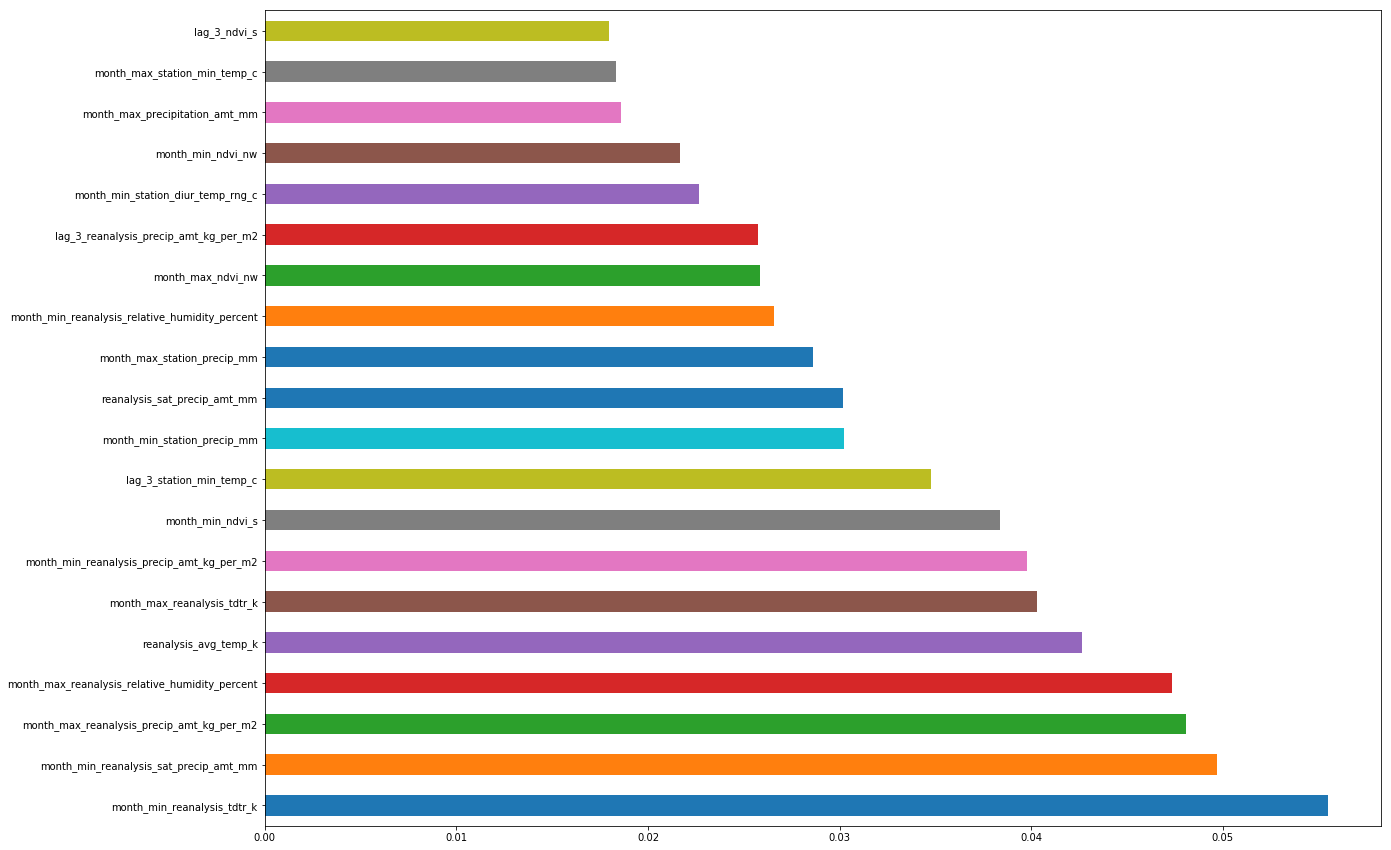

In [21]:
plt.figure(figsize=(20,15))
importance = rf.feature_importances_
feat_importances_act = pd.Series(importance, index=X_train.columns)
feat_importances = feat_importances_act.nlargest(20)
feat_importances.plot(kind='barh')

## linear regresion model

In [14]:
reg = linear_model.Ridge (alpha = 0.5)
reg.fit(X_train[feat_importances_act.nlargest(4).keys()],Y_train)
predict2 = reg.predict(X_test[feat_importances_act.nlargest(4).keys()])     
print(mean_absolute_error(Y_test, [max(x,0) for x in predict2.round(0).astype(int)]))  
predict_lnr = reg.predict(X_testrf[feat_importances_act.nlargest(4).keys()])
predict_lnr= [max(x,0) for x in predict_lnr]

8.146511627906976


In [15]:
Y_New['total_cases'] = np.array(predict_lnr, dtype=np.float32).round(0)
Y_New['total_cases'] = Y_New['total_cases'].astype(int)
Y_New.to_csv('submission_sj.csv')

In [16]:
X_crr = X.copy(deep=True)
X_crr['total_cases'] = Y['total_cases']
corr = X_crr.corr()

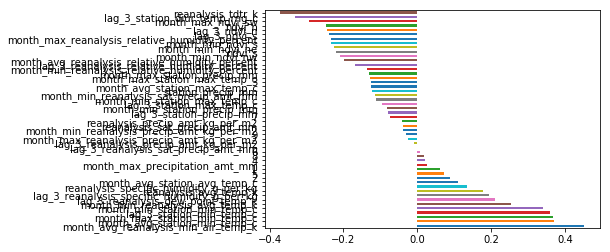

In [17]:
corr.total_cases.drop('total_cases').sort_values(ascending=False).plot.barh()

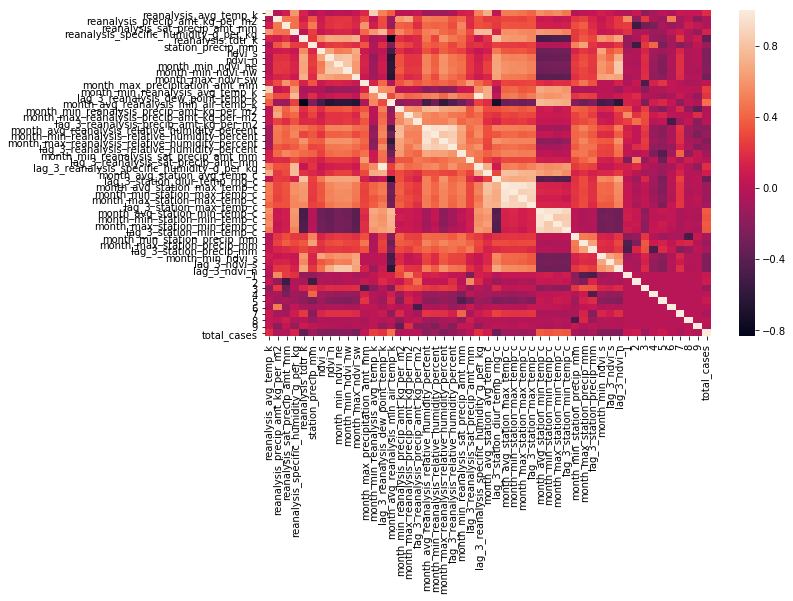

In [18]:
plt.figure(figsize=(10, 6))
sns.heatmap(corr, 
        xticklabels=corr.columns,
        yticklabels=corr.columns)